In [1]:
import cv2 
import numpy as np 
import os 
import matplotlib.pyplot as plt 

In [2]:
Xtrain = [] #array to store training and testing images
Ytrain = [] 

In [3]:
#Data preprocessing 
#Training the model with data from task 1 to use it later as pre-trainined model for transfer learning for MNIST dataset. 
#Here the model is trained for only 10 classes 0-9
from tensorflow.keras.preprocessing.image import ImageDataGenerator
classes = 0 
add = r"trainPart1\train\g" #address of training data
original_data = 0
for data in os.listdir(add[:-2]):
    p = add[:-1] + data + "\g"
    original_data += len(os.listdir(p[:-1]))
    if classes < 10 : #first 10 classes in the training data is 0-9
        for d in os.listdir(p[:-1]):  
            img = cv2.imread(p[:-1] + d) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
            #To reduce the size of the input image for the model and removing the unwanted white space in the image. 
            black = np.column_stack(np.where(img == 0))
            x_values=[i[0] for i in black]
            y_values=[i[1] for i in black]
            xMin , xMax , yMin , yMax = min(x_values) , max(x_values) , min(y_values) , max(y_values)
            img = img[xMin - 10 : xMax + 10 , yMin - 10 : yMax + 10 ] #Creating an ROI around the text and leaving 
            #and leaving a margin of 10px
            img = cv2.resize(img, (28,28)) 
            img = img.reshape(1,img.shape[0],img.shape[1],1)
            datagen = ImageDataGenerator(rotation_range=90) #Image Augmentation to icrease the number of training data 
            it = datagen.flow(img, batch_size=1)
            for i in range(4):
                batch = it.next()
                image = batch[0].astype('uint8')
                Xtrain.append(image)
                Ytrain.append(classes)
        classes += 1 


In [4]:
print("Total number of Classes : " + str(classes))
print("Size of Training data before data augmentation: " + str(original_data))
print("Size of Training data after data augmentation: " + str(len(Xtrain)))

Total number of Classes : 10
Size of Training data before data augmentation: 2480
Size of Training data after data augmentation: 1600


In [5]:
#Data Prepration
from sklearn.utils import shuffle

Xtrain , Ytrain = shuffle(Xtrain , Ytrain) #Shuffling the data to create independent change in the data


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size=0.33, random_state=42) #Spliting the data 
#into training and valditation data 

img_row = x_train[0].shape[0]
img_col = x_train[0].shape[1]

x_train  = np.array(x_train)
x_test  = np.array(x_test)

x_train=x_train.reshape(x_train.shape[0], img_row, img_col, 1)
x_test=x_test.reshape(x_test.shape[0], img_row, img_col, 1)

input_shape = (img_row, img_col, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #data Normalization
x_test /= 255

from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_train.shape[1]


In [6]:
#architecture:
#Model for transfer learning 
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , MaxPooling2D , Flatten,Dropout , BatchNormalization , Activation
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation = 'relu'))
model.add(BatchNormalization()) #To re-center and re-scale the layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3)) #To reduce over-fitting 

model.add(Conv2D(64,kernel_size=(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(classes,activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer=SGD(0.01),metrics=['accuracy'])


In [7]:
from keras.callbacks import ModelCheckpoint
filepath = r"model2_1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 12, 64)        0

In [9]:
history = model.fit(x_train,y_train,batch_size=32,epochs=100, callbacks=callbacks_list ,verbose=1 , validation_data=(x_test,y_test))

Epoch 1/100
34/34 [==============================] - 3s 63ms/step - loss: 3.2729 - accuracy: 0.1261 - val_loss: 2.3009 - val_accuracy: 0.1193

Epoch 00001: val_accuracy improved from -inf to 0.11932, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_1.h5
Epoch 2/100
34/34 [==============================] - 1s 32ms/step - loss: 2.0412 - accuracy: 0.2924 - val_loss: 2.3012 - val_accuracy: 0.0947

Epoch 00002: val_accuracy did not improve from 0.11932
Epoch 3/100
34/34 [==============================] - 1s 30ms/step - loss: 1.8017 - accuracy: 0.3760 - val_loss: 2.2997 - val_accuracy: 0.1080

Epoch 00003: val_accuracy did not improve from 0.11932
Epoch 4/100
34/34 [==============================] - 1s 32ms/step - loss: 1.6077 - accuracy: 0.4626 - val_loss: 2.2991 - val_accuracy: 0.1307

Epoch 00004: val_accuracy improved from 0.11932 to 0.13068, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_1.h5
Epoch 5/100
34/34 [======================

In [57]:
model.save("model2_1.h5") 

In [59]:
model.history.history['accuracy'][-1]

0.9720149040222168

In [71]:
#transfer learning using the pre-trainined model from model trained 

from keras.models import load_model
model2_2 = load_model(r"model2_1.h5")

In [72]:
from keras.models import Sequential, Model
from keras.layers import Input , Dense

ll = model2_2.layers[16].output
ll = Dense(10,activation="softmax")(ll)
#input_data = Input(shape=(28, 28, 1), name='input')
model2_22 = Model(inputs=model2_2.input,outputs=ll)

In [73]:
model2_22.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256 

In [74]:
from keras.callbacks import ModelCheckpoint
filepath = r"\model2_21.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [75]:
from keras.datasets import mnist 
#loading the MNIST dataset 
(x_train, y_train),(x_test,y_test)=mnist.load_data()

img_row = x_train[0].shape[0]
img_col = x_train[0].shape[1]

x_train=x_train.reshape(x_train.shape[0], img_row, img_col, 1)
x_test=x_test.reshape(x_test.shape[0], img_row, img_col, 1)

input_shape = (img_row, img_col, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255


from keras.utils import np_utils 

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_train.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]

In [76]:
from keras.optimizers import SGD
model2_22.compile(loss='categorical_crossentropy',optimizer=SGD(0.01),metrics=['accuracy'])
history1 = model2_22.fit(x_train,y_train,batch_size=32,epochs=10, callbacks=callbacks_list ,verbose=1 , validation_data=(x_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 54s 28ms/step - loss: 0.6948 - accuracy: 0.7894 - val_loss: 0.0547 - val_accuracy: 0.9837

Epoch 00001: val_accuracy improved from -inf to 0.98370, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_21.h5
Epoch 2/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1489 - accuracy: 0.9535 - val_loss: 0.0456 - val_accuracy: 0.9852

Epoch 00002: val_accuracy improved from 0.98370 to 0.98520, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_21.h5
Epoch 3/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1156 - accuracy: 0.9640 - val_loss: 0.0364 - val_accuracy: 0.9882

Epoch 00003: val_accuracy improved from 0.98520 to 0.98820, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_21.h5
Epoch 4/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0912 - accuracy: 0.9730 - val_loss: 0.0329 - val_accuracy: 

In [22]:
#architecture:
#training from scratch 
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , MaxPooling2D , Flatten,Dropout , BatchNormalization , Activation
from keras.optimizers import SGD

model2_3 = Sequential()

model2_3.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=input_shape))
model2_3.add(BatchNormalization())
model2_3.add(Activation('relu'))
model2_3.add(MaxPooling2D(pool_size=(2,2)))

model2_3.add(Conv2D(64,kernel_size=(3,3),activation = 'relu'))
model2_3.add(BatchNormalization()) #To re-center and re-scale the layer
model2_3.add(Activation('relu'))
model2_3.add(MaxPooling2D(pool_size=(2,2)))
model2_3.add(Dropout(0.3)) #To reduce over-fitting 

model2_3.add(Conv2D(64,kernel_size=(3,3),activation = 'relu'))
model2_3.add(BatchNormalization())
model2_3.add(Activation('relu'))
model2_3.add(MaxPooling2D(pool_size=(2,2)))
model2_3.add(Dropout(0.3))

model2_3.add(Flatten())
model2_3.add(Dense(128,activation='relu'))
model2_3.add(Dropout(0.2))

model2_3.add(Dense(classes,activation = 'softmax'))

model2_3.compile(loss='categorical_crossentropy',optimizer=SGD(0.01),metrics=['accuracy'])

In [23]:
model2_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
activation_4 (Activation)    (None, 12, 12, 64)       

In [24]:
from keras.callbacks import ModelCheckpoint
filepath = r"\model2_3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [25]:
history2 = model2_3.fit(x_train,y_train,batch_size=32,epochs=10, callbacks=callbacks_list ,verbose=1 , validation_data=(x_test,y_test))

Epoch 1/10
1875/1875 [==============================] - 62s 32ms/step - loss: 0.7630 - accuracy: 0.7545 - val_loss: 0.0591 - val_accuracy: 0.9819

Epoch 00001: val_accuracy improved from -inf to 0.98190, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_3.h5
Epoch 2/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.1522 - accuracy: 0.9526 - val_loss: 0.0454 - val_accuracy: 0.9860

Epoch 00002: val_accuracy improved from 0.98190 to 0.98600, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_3.h5
Epoch 3/10
1875/1875 [==============================] - 109s 58ms/step - loss: 0.1054 - accuracy: 0.9676 - val_loss: 0.0366 - val_accuracy: 0.9878

Epoch 00003: val_accuracy improved from 0.98600 to 0.98780, saving model to D:\Ananya\IIIT--D\HandWritingRecognition\trainPart1\model2_3.h5
Epoch 4/10
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0894 - accuracy: 0.9725 - val_loss: 0.0327 - val_accuracy: 

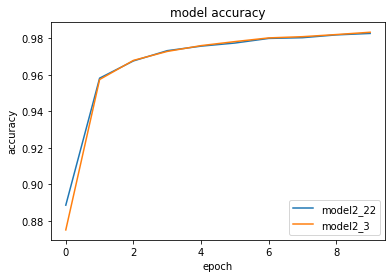

In [77]:
###comparing the models 
# model2_3 : trained from scratch 
# model2_22 : using pretrained model 



### comparing the convergence time 

plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model2_22', 'model2_3'], loc='lower right')
plt.show()

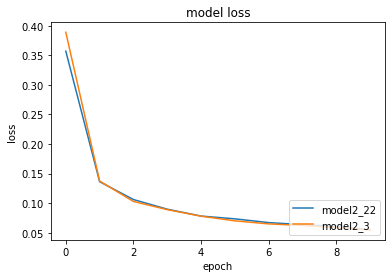

In [78]:
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['model2_22', 'model2_3'], loc='lower right')
plt.show()

In [79]:
#final accuracy
print("Accuracy of the model trained from the scratch is: " + str(history1.history['accuracy'][-1]))
print("Accuracy of the model trained using pretrained model is: " + str(history2.history['accuracy'][-1]))

Accuracy of the model trained from the scratch is: 0.9827333092689514
Accuracy of the model trained using pretrained model is: 0.9833833575248718


In [80]:
print("Validation accuracy of the model trained from the scratch is: " + str(history1.history['accuracy'][-1]))
print("Validation accuracy of the model trained using pretrained model is: " + str(history2.history['accuracy'][-1]))

Validation accuracy of the model trained from the scratch is: 0.9827333092689514
Validation accuracy of the model trained using pretrained model is: 0.9833833575248718


In [81]:
### Confusion Matrix for model trained from scratch
(x_train, y_train),(x_test,y_test)=mnist.load_data()

img_row = x_test[0].shape[0]
img_col = x_test[0].shape[1]

x_test  = np.array(x_test)

x_test=x_test.reshape(x_test.shape[0], img_row, img_col, 1)

x_test = x_test.astype('float32')

x_test /= 255

In [82]:
pred_class = [] #contains the predicted value 
y_ = y_test[:20]
#y_ contains the true value
for img in x_test[:20]:
    img = img.reshape(1,28,28,1)
    pred_class.append(model2_3.predict_classes(img, verbose=1))
    

1/1 [==============================] - 0s 132ms/step


C:\Users\anany\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 0s 8ms/step


In [83]:
from sklearn.metrics import confusion_matrix
cm_scratch=confusion_matrix(y_, pred_class)

In [87]:
### Confusion Matrix for model trained using pre-trained model 

pred_class = [] #contains the predicted value 
y_ = y_test[:20]
#y_ contains the true value
for img in x_test[:20]:
    img = img.reshape(1,28,28,1)
    predict_prob = model2_22.predict(img, verbose=1)
    predict_classes = np.argmax(predict_prob,axis=1)
    pred_class.append(predict_classes)
    #pred_class.append(model2_22.predict_classes(img, verbose=1))
    
    

from sklearn.metrics import confusion_matrix
cm_pretrained=confusion_matrix(y_,pred_class)


1/1 [==============================] - 0s 11ms/step


In [88]:
print("The confusion matrix for the model trained from scratch is : ")
print(cm_scratch)

The confusion matrix for the model trained from scratch is : 
[[3 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 4]]


In [89]:
print("The confusion matrix for the model trained from pretrained model is : ")
print(cm_pretrained)

The confusion matrix for the model trained from pretrained model is : 
[[3 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 4]]
